# Detecting credit card fraud
----


In this project, we will train several models and evaluate how effectively they predict instances of credit card fraud using data based on [this dataset from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The original dataset contains 284,807 transactions made in September 2013 by european cardholders. Out of these transactions, 492 are fraudulent (0.17% of all transactions).

For the purpose of this project, we will work with a shorter version of this dataset (21693 transactions). The target is stored in the **Class** column (where 1 represents an instance of fraud and 0 corresponds to a non-fraudulent transaction).

The available features include:
- confidential variables **V1** to **V28** which are the result of a PCA transformation,
- **Amount** of the transaction.

In [1]:
import numpy as np
import pandas as pd
df= pd.read_csv('fraud_data.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


----
## What percentage of the observations in the dataset are instances of fraud?

In [2]:
def percent_fraud():
    fraud_cases= len(df[df["Class"]==1])
    return fraud_cases/len(df)

percent_fraud()

0.016410823768035772

In the short version of the dataset we are working with, the instances of fraud represent about 1.64% of transactions. With skewed classes, we have to be careful with the metric that we choose to evaluate our model(s).

----
## Dummy classifier

Let's train a dummy classifier that classifies everything as the majority class of the training data. What is the accuracy of this classifier? What is the recall?

In [3]:
# splitting the dataset
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score

def dummy_clf():    
    dummy_majority= DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
    accuracy= dummy_majority.score(X_test, y_test)
    predictions= dummy_majority.predict(X_test)
    recall= recall_score(y_test, predictions)
    return (accuracy, recall)

dummy_clf()

(0.98525073746312686, 0.0)

In the case of highly unbalanced classes, using accuracy to evaluate the performance of a model is a bad choice. Indeed, a dummy classifier that always predicts the majority class of the training dataset has an accuracy score of 98.5%. On the contrary, calculating its recall score indicates that it doesn't perform well: its recall score is 0.

----
## Support Vector Classifier (SVC)

Let's train a SVC using the default parameters. What is the accuracy, recall, and precision of this classifier?

In [5]:
from sklearn.metrics import precision_score
from sklearn.svm import SVC

clf= SVC(C=1e9, gamma=1e-07).fit(X_train, y_train)

def svc_clf():
    accuracy= clf.score(X_test, y_test)
    predictions= clf.predict(X_test)
    recall= recall_score(y_test, predictions)
    precision= precision_score(y_test, predictions)
    return (accuracy, recall, precision)

svc_clf()

(0.99631268436578169, 0.80000000000000004, 0.94117647058823528)

The SVC also has a very high accuracy but its recall score is indeed much better. Its precision score is high as well.

Let's have a look at the confusion matrix of our model.

In [6]:
from sklearn.metrics import confusion_matrix

def conf_matrix():
    predictions= clf.predict(X_test)
    return confusion_matrix(y_test, predictions)

conf_matrix()

array([[5340,    4],
       [  16,   64]])

----
## Logisitic regression classifier

### Precision-recall curve, ROC curve

Let's train a logisitic regression classifier with default parameters and plot a precision-recall curve and a ROC curve using the test set.

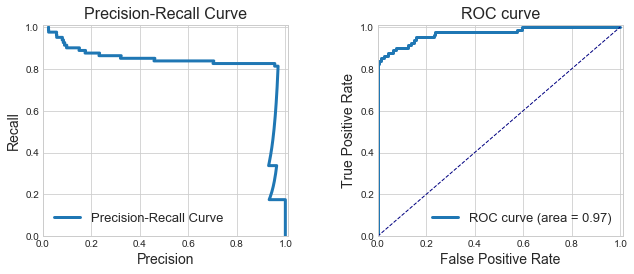

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def log_reg_curves():   
    # creating and training a logistic regression classifier
    clf=LogisticRegression().fit(X_train, y_train)
    
    # getting the decision_function scores
    y_score= clf.decision_function(X_test)

    # figure layout
    fig = plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")
    
    # plotting the precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    plt.subplot(1, 2, 1)
    plt.plot(precision, recall, lw=3, label='Precision-Recall Curve')
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.01])
    plt.xlabel('Precision', fontsize=14)
    plt.ylabel('Recall', fontsize=14)
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.legend(loc='lower left', fontsize=13)

    # plotting the roc curve
    fpr, tpr, _= roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    plt.tight_layout(pad=5)
    
log_reg_curves()

The area under the ROC curve (AUC) is 0.97, suggesting that our classifier performs very well. 

### Optimising parameters with GridSearchCV

We will now use GridSearchCV to optimise the parameters `penalty` and `C` with recall as the scoring method. We will return a 5 by 2 numpy array that we will use to create a heatmap.

In [8]:
from sklearn.model_selection import GridSearchCV

def optimising():    
    clf=LogisticRegression()
    grid_values= {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10]}    
    grid_clf_recall= GridSearchCV(clf, param_grid= grid_values, scoring='recall', return_train_score=True) # cv parameter default= 3 folds
    grid_clf_recall.fit(X_train, y_train)
    results_dict= grid_clf_recall.cv_results_
    return results_dict['mean_test_score'].reshape(4,2)

optimising()

array([[ 0.66666667,  0.76086957],
       [ 0.80072464,  0.80434783],
       [ 0.8115942 ,  0.8115942 ],
       [ 0.80797101,  0.8115942 ]])

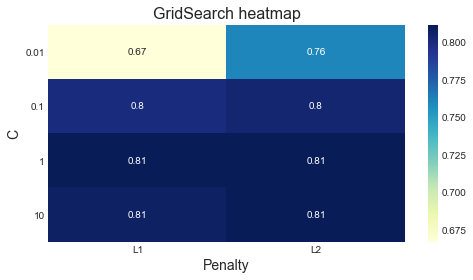

In [9]:
def GridSearch_Heatmap(scores):
    plt.figure(figsize=(8, 4))
    sns.heatmap(scores.reshape(4,2), xticklabels=['L1','L2'], yticklabels=[0.01, 0.1, 1, 10], \
                annot=True, cmap="YlGnBu")
    plt.yticks(rotation=0)
    plt.xlabel('Penalty', fontsize=14)
    plt.ylabel('C', fontsize=14)
    plt.title('GridSearch heatmap', fontsize=16)

GridSearch_Heatmap(optimising())

Having a look at the numpy array of scores and the heatmap, we can tell that an L2 penalty and a C value of 1 or 10 are the best choices to get a high recall score.